# Plot XIFUSIM and SIRENA times of a list of photons

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
import matplotlib.cm as cm
import ipywidgets as widgets
%matplotlib widget

In [9]:
sim = 109
pixel = 957
flux_label = "1000.00"
xifusim_initial_multiple_record = 4
sampling_rate = 130210  # Hz
#record_length = 12700
record_length = 12700

xifusim_file = glob.glob(f"./v5_20250621/flux{flux_label}mcrab/sim_{sim}/crab_flux{flux_label}_Emin2_Emax10_exp*_RA0.0_Dec0.0_*_*_pixel{pixel}_xifusim.fits")[0]
piximpact_file = glob.glob(f"./v5_20250621/flux{flux_label}mcrab/sim_{sim}/crab_flux{flux_label}_Emin2_Emax10_exp*_RA0.0_Dec0.0_*_*_pixel{pixel}_piximpact_toxifusim.fits")[0]
sirena_file = glob.glob(f"./v5_20250621/flux{flux_label}mcrab/sim_{sim}/crab_flux{flux_label}_Emin2_Emax10_exp*_RA0.0_Dec0.0_*_*_pixel{pixel}_sirena.fits")[0]

In [10]:
# read list of PH_ID from xifusim file

with fits.open(xifusim_file) as hdul:
    xifusim_data = hdul["TESRECORDS"].data
    ph_id_col = xifusim_data['PH_ID'].copy()
    time_col = xifusim_data['TIME'].copy()
    adc_col = xifusim_data['ADC'].copy()

xifusim_ph_ids = ph_id_col[xifusim_initial_multiple_record - 1]  # Adjust for zero-based index

# remove 0s from the list
xifusim_ph_ids_non0 = xifusim_ph_ids[xifusim_ph_ids != 0]
print(f"Number of simulated photons in XIFUSIM: {len(xifusim_ph_ids_non0)}")
print(f"XIFUSIM PH_IDs: {xifusim_ph_ids_non0}")

# identify which records in xifusim have these PH_IDs
xifusim_records = np.where((ph_id_col == xifusim_ph_ids).all(axis=1))[0] + 1  # Adjust for one-based index
print(f"XIFUSIM records with these same PH_IDs: {xifusim_records}")
last_xifusim_record = xifusim_records[-1]


# get xifusim records start and end times
extended_start_time = time_col[xifusim_initial_multiple_record - 1]  # Adjust for zero-based index
print(f"XIFUSIM extended start time: {extended_start_time}")
xifusim_start_times = [extended_start_time + ir*record_length / sampling_rate for ir in range(len(xifusim_records))]
print(f"XIFUSIM start times: {xifusim_start_times}")

# identify last EXTENDED record
print(f"Last XIFUSIM record with these PH_IDs: {last_xifusim_record}")
print(f"Last XIFUSIM record start time: {xifusim_start_times[-1]}")  # Adjust for zero-based index

# get real end time of xifusim multiple records
xifusim_last_adc = adc_col[last_xifusim_record - 1]  # Adjust for zero-based index
# identify last non-zero adc value
last_nonzero_index = np.where(xifusim_last_adc != 0)[0][-1]
print(f"Last non-zero ADC index in last XIFUSIM record: {last_nonzero_index}")
print(f"Last non-zero ADC value in last XIFUSIM record: {xifusim_last_adc[last_nonzero_index]}")
xifusim_end_time = xifusim_start_times[-1] + (last_nonzero_index+1) / sampling_rate  # Adjust for zero-based index
print(f"Last XIFUSIM record end time: {xifusim_end_time}")

Number of simulated photons in XIFUSIM: 17
XIFUSIM PH_IDs: [4341 4343 4834 4884 4960 4969 4970 4981 5135 5219 5246 5247 5311 5340
 5373 5399 5775]
XIFUSIM records with these same PH_IDs: [4 5 6]
XIFUSIM extended start time: 0.5623319565974626
XIFUSIM start times: [np.float64(0.5623319565974626), np.float64(0.6598667081526427), np.float64(0.7574014597078228)]
Last XIFUSIM record with these PH_IDs: 6
Last XIFUSIM record start time: 0.7574014597078228
Last non-zero ADC index in last XIFUSIM record: 4727
Last non-zero ADC value in last XIFUSIM record: 6278.987683796087
Last XIFUSIM record end time: 0.7937120349324599


In [11]:
# read times from piximpact file
with fits.open(piximpact_file) as hdul:
    piximpact_data = hdul[1].data
    piximpact_ph_id_col = piximpact_data['PH_ID']
    piximpact_time_col = piximpact_data['TIME']
    piximapct_energy_col = piximpact_data['ENERGY']
    # Filter times for the relevant PH_IDs
    xifusim_pulses_times = piximpact_time_col[np.isin(piximpact_ph_id_col, xifusim_ph_ids_non0)]
    xifusim_pulses_energies = piximapct_energy_col[np.isin(piximpact_ph_id_col, xifusim_ph_ids_non0)]
print(f"Number of pulse times in PIXIMPACT: {len(xifusim_pulses_times)}")
print(f"Pulse times from XIFUSIM (s): {xifusim_pulses_times}")

Number of pulse times in PIXIMPACT: 17
Pulse times from XIFUSIM (s): [0.57384646 0.57389106 0.63348434 0.63914109 0.65122709 0.65203579
 0.65210851 0.65408393 0.67371353 0.68593134 0.68875624 0.68880795
 0.69742187 0.70181722 0.70769608 0.71017852 0.75663359]


In [12]:
sirena_pulses_times = []
sirena_pulses_energies = []

# read sirena file and get times
with fits.open(sirena_file) as hdul:
    sirena_data = hdul[1].data
    sirena_time_col = sirena_data['TIME']
    sirena_ph_id_col = sirena_data['PH_ID']
    sirena_energy_col = sirena_data['SIGNAL']
# for each sirena record, check if PH_ID is equal to xifusim_ph_ids
for irecord in range(len(sirena_ph_id_col)):
    # check that sirena_ph_id_col[irecord] and xifusim_ph_ids arrays are equal
    #print(f"Comparing SIRENA PH_ID {sirena_ph_id_col[irecord]} with XIFUSIM PH_IDs {xifusim_ph_ids}")
    if (sirena_ph_id_col[irecord] == xifusim_ph_ids).all():
        sirena_pulses_times.append(sirena_time_col[irecord])
        sirena_pulses_energies.append(sirena_energy_col[irecord])
        print(f"SIRENA record {irecord+1}: PH_ID={sirena_ph_id_col[irecord]}, TIME={sirena_time_col[irecord]}")
sirena_pulses_times = np.array(sirena_pulses_times)
sirena_pulses_energies = np.array(sirena_pulses_energies)
print(f"Number of pulse times in SIRENA: {len(sirena_pulses_times)}")
print(f"Pulse times from SIRENA (s): {sirena_pulses_times}")

SIRENA record 13: PH_ID=[4341 4343 4834 4884 4960 4969 4970 4981 5135 5219 5246 5247 5311 5340
 5373 5399 5775    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0], TIME=0.573869099885621
SIRENA record 14: PH_ID=[4341 4343 4834 4884 4960 4969 4970 4981 5135 5219 5246 5247 5311 5340
 5373 5399 5775    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0], TIME=0.5739133965974625
SIRENA record 15: PH_ID=[4341 4343 4834 4884 4960 4969 4970 4981 5135 5219 5246 5247 5311

In [13]:
plot = False
if len(xifusim_pulses_times) != len(sirena_pulses_times):
    print("Warning: Number of pulse times in XIFUSIM and SIRENA do not match!")
    plot = True
else:
    print("Number of pulse times in XIFUSIM and SIRENA match.")


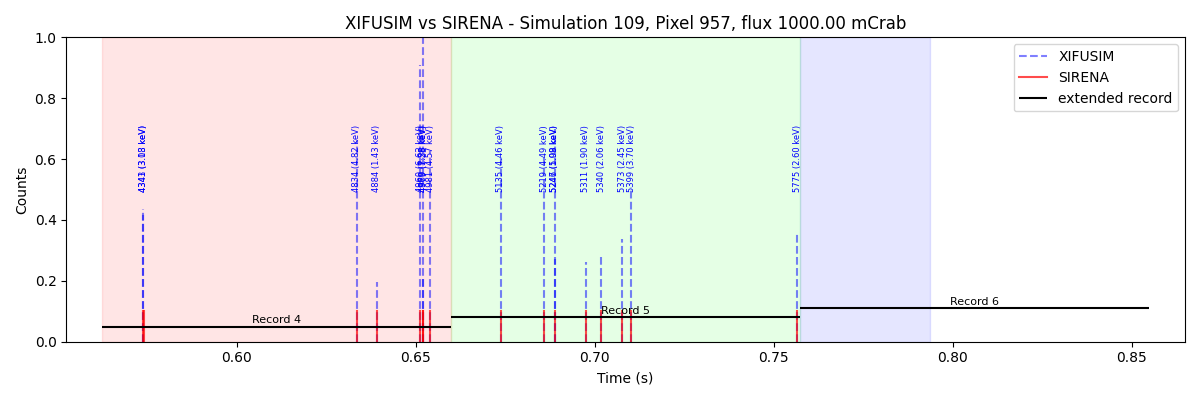

In [15]:
if plot:
    # Plot xifusim and sirena times as vertical lines
    plt.figure(figsize=(12, 4))
    xmin_box=xifusim_start_times[0] - 0.01
    xmax_box=xifusim_start_times[-1] +  record_length/sampling_rate +0.01
    plt.xlim(xmin_box, xmax_box)
    plt.ylim(0, 1)
    # plot PULSES: vertical dashed blue lines for xifusim times and solid red lines for sirena times
    max_energy=np.max(xifusim_pulses_energies)
    for t in xifusim_pulses_times:
        energy = xifusim_pulses_energies[np.where(xifusim_pulses_times == t)[0][0]]
        plt.axvline(x=t, ymin=0,ymax=energy/max_energy, color='blue', linestyle='--', alpha=0.5, label='XIFUSIM' if t == xifusim_pulses_times[0] else "")
        # add label with PH_ID
        ph_id = xifusim_ph_ids[np.where(xifusim_pulses_times == t)[0][0]]
        #plt.text(t-0.002, 0.5, f'{ph_id} ({energy:.2f} keV)', rotation=90, color='blue', fontsize=6, ha='center')
        plt.text(t, 0.5, f'{ph_id} ({energy:.2f} keV)', rotation=90, color='blue', fontsize=6, ha='center')

    for t in sirena_pulses_times:
        plt.axvline(x=t, ymin=0, ymax=0.1, color='red', linestyle='-', alpha=0.7, label='SIRENA' if t == sirena_pulses_times[0] else "")

    # plot RECORDS: shaded regions for records in xifusim
    colors = cm.hsv(np.linspace(0, 1, len(xifusim_start_times)+1))
    for i, start in enumerate(xifusim_start_times):
        #print(f"Shading XIFUSIM record {xifusim_records[i]} starting at {start:.6f} s")
        #print(f"  Ending at {start + record_length/sampling_rate:.6f} s")
        #print(f"    or at {xifusim_end_time:.6f} s if earlier")
        #print(f"Diff: { (start + record_length/sampling_rate) - xifusim_end_time:.6f} s")
        xmax=min(start + record_length/sampling_rate, xifusim_end_time)
        plt.axvspan(xmin=start, xmax=xmax, ymin=0, ymax=1, color=colors[i], alpha=0.1)
        
        # draw horizontal line spanning the region
        if i == len(xifusim_start_times) - 1:
            xmax=max(start + record_length/sampling_rate, xifusim_end_time)
        plt.hlines(y=0.05+i*0.03, xmin=start, xmax=xmax, color='black', label='extended record' if i == 0 else "")
        xtext = start + min((record_length/sampling_rate)/2, (xmax-start)/2)
        ytext = 0.05 + i*0.03 + 0.01
        plt.text(xtext, ytext, f'Record {xifusim_records[i]}', color='black', fontsize=8, ha='center')
        # add label with record

    plt.xlabel('Time (s)')
    plt.ylabel('Counts')
    plt.title(f'XIFUSIM vs SIRENA - Simulation {sim}, Pixel {pixel}, flux {flux_label} mCrab')
    plt.legend()
    plt.tight_layout()
